# Q-2. Take any pdf and your task is to extract the text from that pdf and store it in a csv file and then you need to find the most repeated word in that pdf.

In [76]:
!pip install PyPDF2
from PyPDF2 import PdfReader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
reader = PdfReader('/content/pdf-sample.pdf')

In [78]:
page = reader.pages[0]

In [79]:
text = page.extract_text()
text

"Adobe Acrobat PDF Files\nAdobe® Portable Document Format (PDF) is a universal file format that preserves all\nof the fonts, formatting, colours and graphics of any source document, regardless ofthe application and platform used to create it.\nAdobe PDF is an ideal format for electronic document distribution as it overcomes the\nproblems commonly encountered with electronic file sharing.\n• Anyone, anywhere  can open a PDF file. All you need is the free Adobe Acrobat\nReader. Recipients of other file formats sometimes can't open files because they\ndon't have the applications used to create the documents.\n• PDF files always print correctly  on any printing device.\n• PDF files always display exactly  as created, regardless of fonts, software, and\noperating systems. Fonts, and graphics are not lost due to platform, software, and\nversion incompatibilities.\n• The free Acrobat Reader is easy to download and can be freely distributed by\nanyone.\n• Compact PDF files are smaller than the

In [80]:
text= text.strip() # remove whitespace
text= text.replace("\n", " ")# replace newlines with space
text= text.replace(",", " ")
text=text.replace(".", " ")

In [81]:
words= ""
for w in text:
  words += w


In [82]:
import  nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [83]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
stop_words= stopwords.words('english')

In [85]:
clean_words= [w for w in words.split(" ") if w not in stop_words]

In [86]:
fd= nltk.FreqDist(w.lower() for w in clean_words if len(w)>3)
fd

FreqDist({'files': 6, 'file': 4, 'adobe': 3, 'acrobat': 3, 'document': 3, 'format': 3, 'fonts': 3, 'graphics': 2, 'source': 2, 'regardless': 2, ...})

In [87]:
wc= WordCloud().generate_from_frequencies(fd)

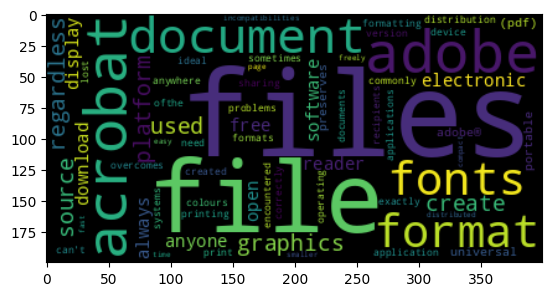

In [88]:
plt.figure()
plt.imshow(wc, interpolation= 'bilinear')

The most repeated word in the pdf is files.

# Q-3. from question 2, As you got the CSV and now you need perform key word
extraction from that csv file and do the Topic modeling

In [89]:
import csv
import pandas as pd

In [90]:
df1= words.split(" ")
df= pd.DataFrame(df1)
df.to_csv('filename2', mode='a', na_rep='Nan', index=False)

In [91]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [92]:
# lowercase
text=text.lower()

In [93]:
#remove tags
text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

In [94]:
# remove special characters and digits
text=re.sub("(\\d|\\W)+"," ",text)

In [95]:
##Convert to list from string
text = text.split()

In [96]:
# remove stopwords
text = [word for word in text if word not in stop_words]

In [97]:
# remove words less than three letters
text = [word for word in text if len(word) >= 3]

In [98]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
# lemmatize
lmtzr = WordNetLemmatizer()
text = [lmtzr.lemmatize(word) for word in text]

In [100]:
docs= " ".join(text)

CountVectorizer to create a vocabulary and generate word counts

In [101]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
docs = docs.split()
#create a vocabulary of words, 
cv=CountVectorizer(max_df=0.95,         # ignore words that appear in 95% of documents
                   max_features=10000,  # the size of the vocabulary
                   ngram_range=(1,3)    # vocabulary contains single words, bigrams, trigrams
                  )
word_count_vector=cv.fit_transform(docs)

CPU times: user 2.13 ms, sys: 10 µs, total: 2.14 ms
Wall time: 2.15 ms


TfidfTransformer to Compute Inverse Document Frequency (IDF)

In [102]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

CPU times: user 1.43 ms, sys: 23 µs, total: 1.45 ms
Wall time: 1.5 ms


TfidfTransformer()

In [103]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [104]:
# get feature names
feature_names=cv.get_feature_names_out()

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [105]:
def get_keywords(idx, docs):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs[idx]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

In [106]:
def print_results(idx,keywords, df):
  for k in keywords:
    print(k,keywords[k])

In [112]:
for idx in range (0,10):
  keywords=get_keywords(idx, docs)
  print_results(idx,keywords, df)

adobe 1.0
acrobat 1.0
pdf 1.0
file 1.0
adobe 1.0
portable 1.0
document 1.0
format 1.0
pdf 1.0
universal 1.0


Keywords found.

In [114]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in docs]

In [117]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [118]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [119]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.069*"acrobat" + 0.048*"electronic" + 0.048*"software"'), (1, '0.151*"file" + 0.107*"pdf" + 0.063*"format"'), (2, '0.088*"adobe" + 0.088*"document" + 0.047*"application"')]


Topic Modelling done.

# Q-4. Take any text file and now your task is to Text Summarization without using
hugging transformer library

TEXT SUMMARIZATION USING THE FREQUENCY METHOD

In [125]:
import pandas as pd
import numpy as np
data = "My name is shubham kumar shukla. It is my pleasure to get the opportunity to write article for xyz related to nlp"
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
def solve(text):
  stopwords1 = set(stopwords.words("english"))
  words = word_tokenize(text)
  freqTable = {}
  for word in words:
    word = word.lower()
    if word in stopwords1:
      continue
    if word in freqTable:
      freqTable[word] += 1
    else:
      freqTable[word] = 1

  sentences = sent_tokenize(text)
  sentenceValue = {}
  for sentence in sentences:
    for word, freq in freqTable.items():
      if word in sentence.lower():
        if sentence in sentenceValue:
          sentenceValue[sentence] += freq
        else:
          sentenceValue[sentence] = freq
  sumValues = 0
  for sentence in sentenceValue:
    sumValues += sentenceValue[sentence]
  average = int(sumValues / len(sentenceValue))

  summary = ''
  for sentence in sentences:
    if (sentence in sentenceValue) and(sentenceValue[sentence] > (1.2 * average)):
      summary += "" + sentence
  return summary

In [126]:
solve(data)

'It is my pleasure to get the opportunity to write article for xyz related to nlp'

LSA

In [ ]:
!pip install sumy

In [133]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
def lsa_method(text):
  parser = PlaintextParser.from_string(text, Tokenizer("english"))
  summarizer_lsa = LsaSummarizer()
  summary_2 = summarizer_lsa(parser.document, 2)
  dp = []
  for i in summary_2:
    lp = str(i)
  dp.append(lp)
  final_sentence = ' '.join(dp)
  return final_sentence

In [134]:
lsa_method(data)

'It is my pleasure to get the opportunity to write article for xyz related to nlp'